
## CDPT model from Arredondo & Billen, 2016

A simplified composition dependent phase-transition model capturing density jumps at phase transitions is generated for silumating subduction zone geodynamics.
Usage of this model in a Bousinesq approximation is appropriate(i.e. incompressible).

The purpose of this notebook is to show the implementation with python. On the other hand, this model is fully implemented in my branch of ASPECT(https://github.com/lhy11009/aspect, branch: TwoDSubduction).

Please refer to the original paper, and follow its reference to the phase transitions.

[link to the paper](http://dx.doi.org/10.1016/j.jog.2016.05.009)

### contacts

1. Haoyuan Li (hylli@ucdavis.ucdavis.edu)

2. Magali Billen (mibillen@ucdavis.edu)


### contents

Parameterization is read in from a json file(i.e. phases_1_0.json). A different parameterization could be adapted by modifying this file.

Figures 1A, B, C are reproduced, exhibiting the density profile and slab buoyancy.
The density profile is then compared with density profile from Chust et al 2017
(https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JB014501)

#### Parameterization of compositions in the json file

Here is the content of the json file.

A json file has the same format of a python dictionary. The keys at level 0 are names of compositions, including "background", "spharz" and "spcrust". Background stands for the pyrolite mantle. spharz stands for the harzburgitic slab(i.e. depleted). And the spcrust is the crustal slab.

At level 1, the keys are phase transition parameterization of individual compositions, including the base density(i.e surface density), density difference between two adjacent phases and the corresponding material propotions at phase transitions(xc).

'xc' serves the purpose to bind individual compositions to mineral compositions. For instance, the fisrt number for 'background', 0.55, means there is 55% olivine in the pyrolite composition. For complete explanation, please refer to the original paper.

    {
        "_comments": ["This is the input of compositional phases, taken from table 1 of Arredondo& Billen 2017"],
        "background": {
            "_comments": ["Pyrolite composition: 55% olivine, 40% pyroxene, 5% garnet",
                          "These entries are listed by depth"],
            "rho_base": 3300.0,
            "drho": [171.60, 86.790, 221.10, 298.90, 184.80, 208.04, 386.10],
            "xc": [0.55, 0.55, 0.05, 0.55, 0.4, 0.4, 0.4]
        },
        "spharz": {
            "_comments": ["Harzburgite composition: 80% olivine, 20% pyroxene"],
            "rho_base": 3235.0,
            "drho": [171.60, 86.790, 221.10, 298.90, 184.80, 208.04, 386.10],
            "xc": [0.8, 0.8, 0.0, 0.8, 0.20, 0.20, 0.20]
        },
        "spcrust": {
            "_comments": ["basalt composition: total garnet in MTZ in this paper",
                          "the 0.33, 0.67 numbers are picked up to mimic a whole mineralogy"],
            "rho_base": 3000.0,
            "drho": [540.0, 221.10, 386.10],
            "xc": [1.0, 0.33, 0.67]
        }
    }

#### parameterization of phase transitions

These are hardwired seperately at the start the third code block down below.

### full reference

1. Arredondo, K. M., & Billen, M. I. (2016). The effects of phase transitions and compositional layering in two-dimensional kinematic models of subduction. Journal of Geodynamics, 100, 159-174.

2. Chust, T. C., Steinle‐Neumann, G., Dolejš, D., Schuberth, B. S. A., & Bunge, H. P. (2017). MMA‐EoS: A computational framework for mineralogical thermodynamics. Journal of Geophysical Research: Solid Earth, 122(12), 9881-9920.



In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt

### utility functions

In [2]:
# utility functions

# point ot a line
def compute_point_to_line (temperature, depth, T, P, W, slope, by_depth, is_negative, is_vertical):
    '''
    In this approach, we define a transition as a solid line and a range.
    The solid line is a rigid boundary for the new phase.
    While the range is a width of transition. 
    '''
    deviation = 0.0
    if (is_vertical):
        deviation = temperature - T
    else:
        deviation = depth - P - slope * (temperature - T)
    # In this approach, a transition must has a direction in defination
    # We need an opposite direction when the transition defined from higher pressure to lower pressure.
    if (is_negative):
        deviation *= -1.0
    # Deviation must be smaller than 2*W, value for function would be 0.04 there.
    is_in = (deviation > -2.0 * W)
    return [is_in, deviation]


# phases
def compute_phases_properties(phase_index, temperature, depth, 
                              densities, transition_depths, transition_temperatures,\
                              transition_widths, transition_slopes):
    '''
    This function takes in temperature and depth pointwise.
    Within its scope, individual phase transitions are handled seperately and 
    combined to yield a final number for density.
    '''
    pressure_depth_derivative = 3300 * 10.0  #
    
    index_410 = 0 
    index_520 = 1 
    index_560 = 2 
    index_660 = 3 
    index_660_gt = 4 
    index_660_gt1 = 5 
    index_660_gt_combined = 6 
    
    ## initiate varibles 
    function_value = 0.0
    phase_index_pyrolite = 0
    
    
    ## 410
    d410 = transition_depths[index_410]
    T410 = transition_temperatures[index_410]
    W410 = transition_widths[index_410]
    slope410 = transition_slopes[index_410]
    result410 = compute_point_to_line(temperature, depth, T410, d410, W410,\
                                      slope410/pressure_depth_derivative, True, False, False)
    
    ## 520
    d520 = transition_depths[index_520]
    T520 = transition_temperatures[index_520]
    W520 = transition_widths[index_520]
    slope520 = transition_slopes[index_520]
    result520 = compute_point_to_line(temperature, depth, T520, d520, W520,\
                                      slope520/pressure_depth_derivative, True, False, False)
        
    ## 560
    d560 = transition_depths[index_560]
    T560 = transition_temperatures[index_560]
    W560 = transition_widths[index_560]
    slope560 = transition_slopes[index_560]
    result560 = compute_point_to_line(temperature, depth, T560, d560, W560,\
                                   slope560/pressure_depth_derivative, True, False, False)
        
    ## 660
    d660 = transition_depths[index_660]
    T660 = transition_temperatures[index_660]
    W660 = transition_widths[index_660]
    slope660 = transition_slopes[index_660]
    result660 = compute_point_to_line(temperature, depth, T660, d660, W660,\
                                      slope660/pressure_depth_derivative, True, False, False)
        
    ## 660 for gt, part 0
    d660_gt = transition_depths[index_660_gt]
    T660_gt = transition_temperatures[index_660_gt]
    W660_gt = transition_widths[index_660_gt]
    slope660_gt = transition_slopes[index_660_gt]
    result660_gt = compute_point_to_line(temperature, depth, T660_gt, d660_gt, W660_gt,\
                                         slope660_gt/pressure_depth_derivative, True, False, False)
        
    ## 660 for gt, part 1 
    d660_gt1 = transition_depths[index_660_gt1]
    T660_gt1 = transition_temperatures[index_660_gt1]
    W660_gt1 = transition_widths[index_660_gt1]
    slope660_gt1 = transition_slopes[index_660_gt1]
    result660_gt1 = compute_point_to_line(temperature, depth, T660_gt1, d660_gt1, W660_gt1,\
                                          slope660_gt1/pressure_depth_derivative, True, False, False)
        
    ## 660 for gt, combined
    ##  phase_index_660 = 0
    d660_gt_combined = transition_depths[index_660_gt_combined]
    T660_gt_combined = transition_temperatures[index_660_gt_combined]
    W660_gt_combined = transition_widths[index_660_gt_combined]
    slope660_gt_combined = transition_slopes[index_660_gt_combined]
    result660_gt_combined = compute_point_to_line(temperature, depth, T660_gt_combined, d660_gt_combined,\
                                                  W660_gt_combined, slope660_gt_combined/pressure_depth_derivative,\
                                                  True, False, False)
    
    
    if (result410[0]):
        ## 410 for pyrolite
        if(phase_index == index_410):
            function_value += 0.5*(1.0 + np.tanh(result410[1]/W410))
    
    if (result520[0]):
        # 520 for pyrolite
        if(phase_index == index_520):
            function_value += 0.5*(1.0 + np.tanh(result520[1]/W520))
    
    if (result560[0]):
        # 560 for pyrolite, Gt -> CaPv + Gt
        if(phase_index == index_560):
            function_value += 0.5*(1.0 + np.tanh(result560[1]/W560))
    
    if (result660[0]):
        # 660 for pyrolite, rw -> brg + fp
        if(phase_index == index_660):
            function_value += 0.5*(1.0 + np.tanh(result660[1]/W660))
    
    if (result660_gt[0] and temperature < T660_gt):
        # 660 for pyrolite, gt -> il
        if(phase_index == index_660_gt):
            function_value += 0.5*(1.0 + np.tanh(result660_gt[1]/W660_gt))
    
    if (result660_gt1[0] and temperature < T660_gt1):
        # 660 for pyrolite, il -> brg
        if(phase_index == index_660_gt1):
            function_value += 0.5*(1.0 + np.tanh(result660_gt1[1]/W660_gt1))
    
    if (result660_gt_combined[0] and temperature >= T660_gt_combined):
      # 660 for pyrolite combined, at higher temperature, gt -> brg
        if(phase_index == index_660_gt_combined):
            function_value += 0.5*(1.0 + np.tanh(result660_gt_combined[1]/W660_gt_combined))
    
    return function_value

### Parameterization of phase transitions

For details, refer to table 1 in the
paper.

#### pyrolite and harzburgite

Different proportion of minerals are assigned for these two. Comparatively, pyrolite contains less olivine and more pyroxene.

In [3]:
# Compute composition density with a constant temperature
# values for phase transition properties
# pyrolite (mantle)
number_of_phase_transitions = 7
transition_depths = [410e3, 520e3, 560e3, 670e3, 670e3, 670e3, 670e3]
transition_temperatures = [1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0]
transition_widths = [13e3, 25e3, 60e3, 5e3, 5e3, 5e3, 50e3]
transition_slopes = [4e6, 4.1e6, 4e6, -2e6, 4e6, -3.1e6, 1.3e6]
# values of these densities are not important, the difference is
phase_densities = [3300.0, 3394.4, 3442.1, 3453.2, 3617.6, 3691.5, 3774.7, 3929.1]

n = 100
temperature = 1620.0
depths = np.linspace(0, 2890e3, n)
densities = np.zeros(n)
phase_function_values = np.zeros(number_of_phase_transitions)

j = 0
for depth in depths:
    density = phase_densities[0]
    for i in range(number_of_phase_transitions):
        phase_function_values[i] = compute_phases_properties(i, temperature, depth, phase_densities, transition_depths,
                                                  transition_temperatures, transition_widths, transition_slopes)
    for i in range(number_of_phase_transitions):
        density += phase_function_values[i] * (phase_densities[i+1] - phase_densities[i])
    densities[j] = density
    j += 1

In [4]:
# harzburgite
number_of_phase_transitions = 7
transition_depths = [410e3, 520e3, 560e3, 670e3, 670e3, 670e3, 670e3]
transition_temperatures = [1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0]
transition_widths = [13e3, 25e3, 60e3, 5e3, 5e3, 5e3, 50e3]
transition_slopes = [4e6, 4.1e6, 4e6, -2e6, 4e6, -3.1e6, 1.3e6]
# values of these densities are not important, the difference is
phase_densities = [3235.0, 3372.3, 3441.7, 3441.7, 3680.8, 3717.8, 3759.4, 3836.6]

temperature = 1000  # compute at cold slab condition
depths = np.linspace(0, 2890e3, n)
densities1 = np.zeros(n)
phase_function_values = np.zeros(number_of_phase_transitions)

j = 0
for depth in depths:
    density = phase_densities[0]
    for i in range(number_of_phase_transitions):
        phase_function_values[i] = compute_phases_properties(i, temperature, depth, phase_densities, transition_depths,
                                                  transition_temperatures, transition_widths, transition_slopes)
    for i in range(number_of_phase_transitions):
        density += phase_function_values[i] * (phase_densities[i+1] - phase_densities[i])
    densities1[j] = density
    j += 1

### eclogite transitions

I continue to use the functions defined above to compute phase transition for eclogite.
This is actually wrong due to the presence of quartz, which is not included in the mineral phase transitions.
However, the density profile could be toned by the value of 'xc' to have similar density jumps, as is the approach in the paper.
Thus, it is merely a substitution for the real scenario in order to account for dynamic consequences.

In [5]:
# eclogite
# eclogite phase-transition parameters
number_of_phase_transitions = 7
transition_depths = [410e3, 520e3, 665e3, 670e3, 720e3, 720e3, 720e3]
transition_temperatures = [1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0]
transition_widths = [5e3, 5e3, 160e3, 5e3, 20e3, 20e3, 20e3]
transition_slopes = [4e6, 4.1e6, 4e6, -2e6, 1.3e6, 1.3e6, 1.3e6]
# values of these densities are not important, the difference is
phase_densities = [3540.0, 3540.0, 3540.0, 3618.3, 3618.3, 3901.9, 3901.9, 3901.9]

temperature = 1000.0  # computed at cold slab condition
depths = np.linspace(0, 2890e3, n)
densities2 = np.zeros(n)
phase_function_values = np.zeros(number_of_phase_transitions)

j = 0
for depth in depths:
    density = phase_densities[0]
    for i in range(number_of_phase_transitions):
        phase_function_values[i] = compute_phases_properties(i, temperature, depth, phase_densities, transition_depths,
                                                  transition_temperatures, transition_widths, transition_slopes)
    for i in range(number_of_phase_transitions):
        density += phase_function_values[i] * (phase_densities[i+1] - phase_densities[i])
    densities2[j] = density
    j += 1

## Lithosphere density

The lithosphere contains a 7.5 km-thick crustal layer and a 37.5 km-thick harzburgite layer.

In [6]:
# Oceanic lithosphere
hc = 7.5e3
hhz = 27.7e3
densities3 = (hhz * densities1 + hc * densities2) / (hc + hhz)

### Now, plot density profile, compare with output from fisrt principal observation and seismic observation
A profile of pyrolite model from Chust et al 17 paper is included for comparison.

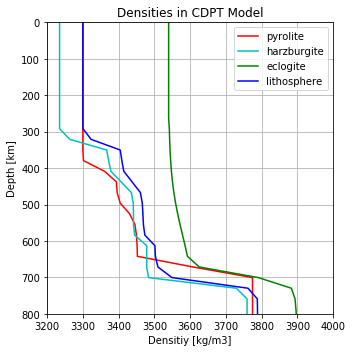

In [7]:


# data from Chust 17
Chust17_pyrolite = np.array([
  [0.37078107742533817, 3.1425201813692216], 
  [0.950936590564412, 3.2249689538700497],
  [4.289074088639609, 3.3645200063366243],
  [13.733855181574159, 3.6325618236181016],
  [13.913762104113376, 3.7473406677161245],
  [15.29053749408711, 3.7902418219342437],
  [18.542044934634184, 3.850878430998938],
  [19.224893623385242, 3.908204043696113],
  [22.7711869758023, 3.9795712587613234],
  [23.26083512704819, 4.008218112771951],
  [23.325863060256637, 4.227045194967481],
  [29.223242999526967, 4.430894804301371],
  [54.81555663135366, 4.7545978736862855]
])

fig, ax = plt.subplots(figsize=(5, 5))
# pyrolite
ax.set_xlim([3200, 4000])
ax.set_ylim([0, 800])
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Densitiy [kg/m3]')
ax.invert_yaxis()
ax.set_title("Densities in CDPT Model")
ax.grid()

# pyrolite
ax.plot(densities, depths/1e3, 'r', label='pyrolite')
# harzburgite
ax.plot(densities1, depths/1e3, 'c', label='harzburgite')
# eclogite
ax.plot(densities2, depths/1e3, 'g', label='eclogite')
# lithosphere
ax.plot(densities3, depths/1e3, 'b', label='lithosphere')
# layout
ax.legend()
fig.tight_layout()

### figure 1a

This figures exhibit the change of compositional density through mantle phase transitions.
The harzburgite and eclogite compositions are computed with a cold temperature of the slab(i.e. 1000 K) while the pyrolite mantle is computed assuming mantle temperature of 1673K.
a no compressibility assumption is applied to all.

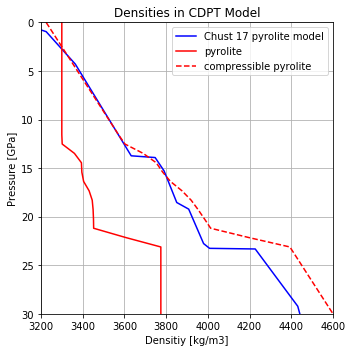

In [27]:
# pyrolite from the Chust 17 paper
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title("Densities in Chust 17 paper")
ax.set_ylim([0, 30])
ax.set_xlim([3200, 4600])
ax.set_ylabel('Pressure [GPa]')
ax.set_xlabel('Densitiy [kg/m3]')
ax.invert_yaxis()
ax.set_title("Densities in CDPT Model")
ax.grid()
ax.plot(Chust17_pyrolite[:, 1]*1e3, Chust17_pyrolite[:, 0], 'b', label='Chust 17 pyrolite model')
# modified pyrolite curve from CDPT model
pressures = depths * 3300 * 10
modified_densities = densities + pressures * 3e-8 - 75 # add a slope and a migration
ax.plot(densities, pressures/1e9, 'r', label='pyrolite')
ax.plot(modified_densities, pressures/1e9, 'r--', label='compressible pyrolite')
ax.legend()
fig.tight_layout()

### Figure: comparism between our model and Chust 17 paper

A comparism to a mantle density profile from the Chust 17 paper is shown here. 
I modified the original pyrolite curve with a slope and a lateral migration.
This is a simplified approach, one should take depth-varying thermal parameters and a
pressure profile to derive the density difference due to compressibility in order to be more strict.

### pyrolite slab

The calculation is identical to the pyrolite mantle except for the cold slab temperature

In [9]:
# Compute composition density with a constant temperature
# values for phase transition properties
# pyrolite (mantle)
number_of_phase_transitions = 7
transition_depths = [410e3, 520e3, 560e3, 670e3, 670e3, 670e3, 670e3]
transition_temperatures = [1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0, 1662.0]
transition_widths = [5e3, 5e3, 5e3, 5e3, 5e3, 5e3, 5e3]
transition_slopes = [4e6, 4.1e6, 4e6, -2e6, 4e6, -3.1e6, 1.3e6]
# values of these densities are not important, the difference is
phase_densities = [3300.0, 3394.4, 3442.1, 3453.2, 3617.6, 3691.5, 3774.7, 3929.1]

n = 100
temperature = 1000.0
depths = np.linspace(0, 2890e3, n)
densities4 = np.zeros(n)
phase_function_values = np.zeros(number_of_phase_transitions)

j = 0
for depth in depths:
    density = phase_densities[0]
    for i in range(number_of_phase_transitions):
        phase_function_values[i] = compute_phases_properties(i, temperature, depth, phase_densities, transition_depths,
                                                  transition_temperatures, transition_widths, transition_slopes)
    for i in range(number_of_phase_transitions):
        density += phase_function_values[i] * (phase_densities[i+1] - phase_densities[i])
    densities4[j] = density
    j += 1

## Buoyancy of the slab

The buoyancy of a 100-km thick slab is derived.

The buoyancy of individual compositions are computed first.

The buoyancy of a composite slab of 7.5km-thick eclogite, 27.7 km-thick harzburgite, and 64.8 km-thick mantle pyrolite is then derived

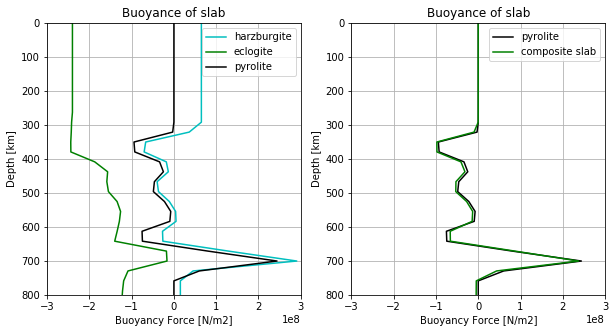

In [10]:
grav_acc = 10
slab_width = 100e3

# density anamoly & buoyancy of the harzburgite layer
diff_densities1 = densities1 - densities
buo1 = - diff_densities1 * grav_acc * slab_width
# density anamoly & buoyancy of the crustal layer
diff_densities2 = densities2 - densities
buo2 = - diff_densities2 * grav_acc * slab_width
# density anamoly & buoyancy of the pyrolite slab layer
diff_densities4 = densities4 - densities
buo4 = - diff_densities4 * grav_acc * slab_width

# density anamoly & buoyancy of the pyrolite slab layer
hpr = 64.8e3
buoS = - (diff_densities1 * hhz + diff_densities2 * hc + diff_densities4 * hpr) * grav_acc

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_xlim([-3e8, 3e8])
axs[0].set_ylim([0, 800])
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('Buoyancy Force [N/m2]')
axs[0].invert_yaxis()
axs[0].set_title("Buoyance of slab")
axs[0].grid()
axs[0].plot(buo1, depths/1e3, 'c', label='harzburgite')
axs[0].plot(buo2, depths/1e3, 'g', label='eclogite')
axs[0].plot(buo4, depths/1e3, 'k', label='pyrolite')
axs[0].legend()
# second plot
axs[1].set_xlim([-3e8, 3e8])
axs[1].set_ylim([0, 800])
axs[1].set_ylabel('Depth [km]')
axs[1].set_xlabel('Buoyancy Force [N/m2]')
axs[1].invert_yaxis()
axs[1].set_title("Buoyance of slab")
axs[1].grid()
axs[1].plot(buo4, depths/1e3, 'k', label='pyrolite')
axs[1].plot(buoS, depths/1e3, 'g', label='composite slab')
axs[1].legend()

### figure 1b

There seems to be a little bit mismatch for harzbargite composition as a result of lack of density crossover between pyrolitie and harzburgite in the previous plot.